In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'/data/aqvs/notebooks'

In [3]:
import sys, glob, shutil
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'/data/aqvs'

In [4]:
import cv2
print(cv2.__version__)
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

4.1.0


In [5]:
# Some function definition:
def plthist(image):    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    return plt.show()

## Loading data

In [6]:
base = "data/YE358311"
healthy = os.path.join(base, "healthy")
defect = os.path.join(base, "defect")

In [7]:
healthy_files = glob.glob(healthy+"/*.jpg")
defect_files = glob.glob(defect+"/*.jpg")

In [17]:
healthy_file = os.path.join(base, "healthy","IMG20180905151148.jpg")
defect_file = os.path.join(base, "defect","IMG20180905150209.jpg")

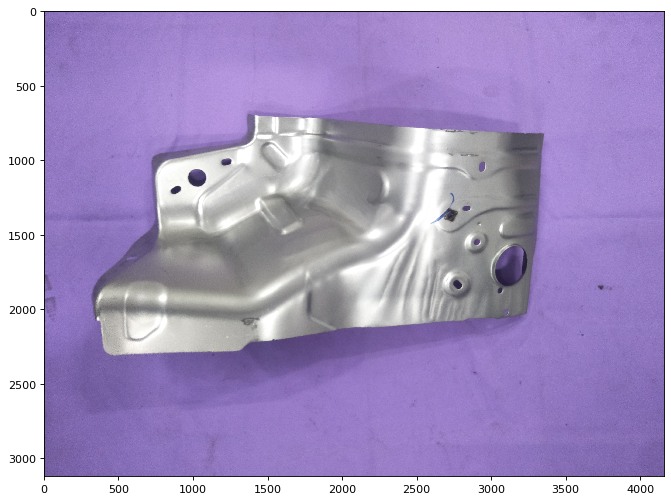

In [18]:
healthy = cv2.imread(healthy_file)
healthy = healthy[..., ::-1]
f = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(healthy)

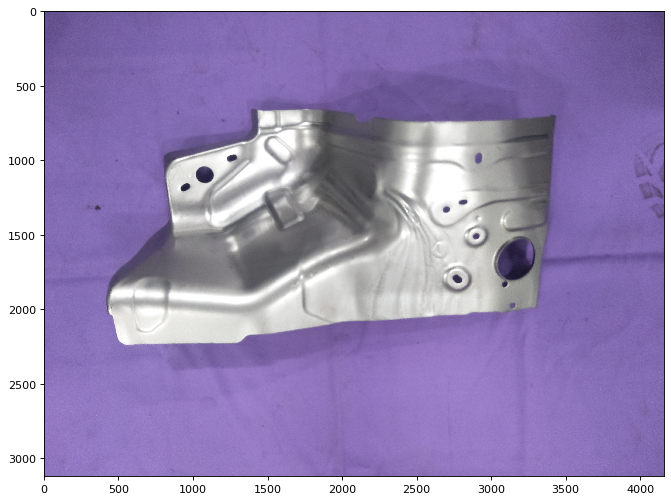

In [19]:
defect = cv2.imread(defect_file)
defect = defect[..., ::-1]
f = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(defect)

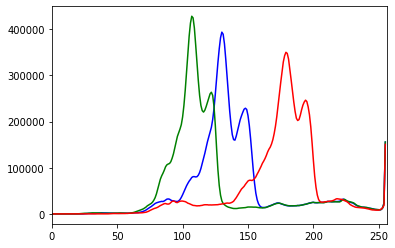

In [20]:
plthist(defect)

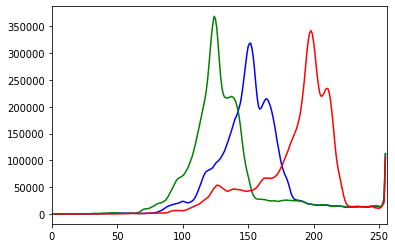

In [21]:
plthist(healthy)

## Thresholding

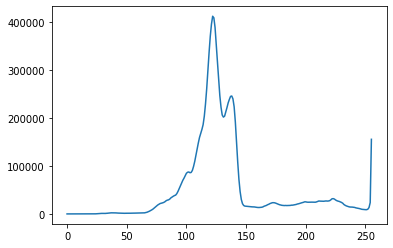

In [22]:
bw = cv2.cvtColor(defect, cv2.COLOR_RGB2GRAY)
histr = cv2.calcHist([bw],[0],None,[256],[0,256])
plt.plot(histr)

Text(0.5, 1.0, 'Otsu thresholded image')

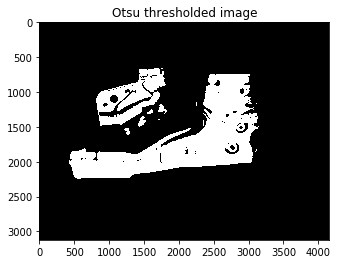

In [23]:
ret2,otsu = cv2.threshold(bw,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu, cmap='gray')
plt.title('Otsu thresholded image')

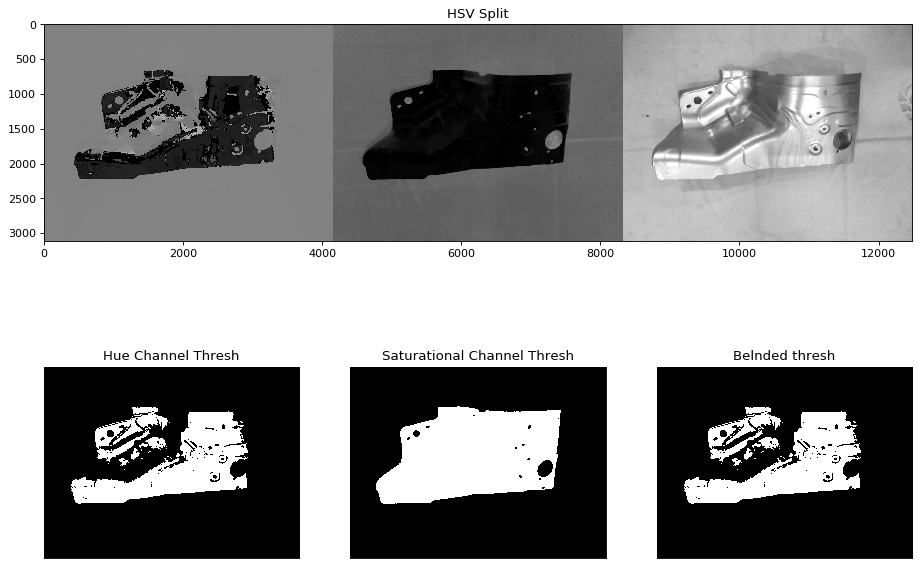

In [24]:
img = defect.copy()
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]
    
hsv_split = np.concatenate((h,s,v), axis=1)

# Otsu thresholding on hue channel
ret, hue = cv2.threshold(h,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Otsu thresholding on sat channel
ret, sat = cv2.threshold(s,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

blended = cv2.bitwise_and(sat,hue)

titles = ['HSV Split','Hue Channel Thresh','Saturational Channel Thresh','Belnded thresh']
images = [hsv_split, hue, sat, blended ]

f = plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot2grid((2,3),(0,0),colspan=3), plt.imshow(images[0],'gray')
plt.title(titles[0])

for i in range(1,4):
    plt.subplot(2,3,i+3),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

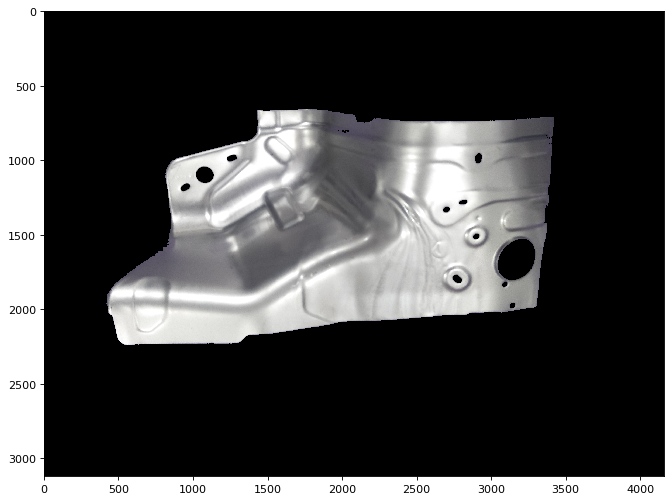

In [25]:
#Preparing segmented image
mask = cv2.merge((sat,sat,sat))
new= cv2.bitwise_and(img, mask)
f = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(new)

In [55]:
import cv2
import math
import numpy as np
import scipy.ndimage

In [56]:
def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    winE = np.array([[0, 0, 0],[1, 1, 1], [0, 0, 0]])
    winSE = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    winS = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
    winSW = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])

    magE = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    mag[ang_quant == 0] = magE[ang_quant == 0]
    mag[ang_quant == 1] = magSE[ang_quant == 1]
    mag[ang_quant == 2] = magS[ang_quant == 2]
    mag[ang_quant == 3] = magSW[ang_quant == 3]
    return mag

def non_max_suppression(data, win):
    data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

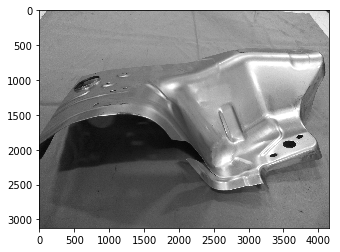

In [101]:
# start calulcation
count_white = 0
gray = bw
plt.imshow(gray, cmap="gray")

In [102]:
#with_nmsup = True #apply non-maximal suppression
#fudgefactor = 1 #with this threshold you can play a little bit
#sigma = 21 #for Gaussian Kernel
#kernel = 2*math.ceil(2*sigma)+1 #Kernel size

gray = gray/255.0
blur = cv2.GaussianBlur(gray, (85, 85), 21)
gray = cv2.subtract(gray, blur)

# compute sobel response
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=31)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=31)
mag = np.hypot(sobelx, sobely)
ang = np.arctan2(sobely, sobelx)

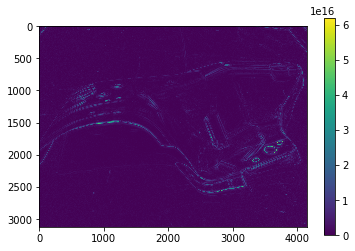

In [103]:
plt.imshow(mag)
plt.colorbar()

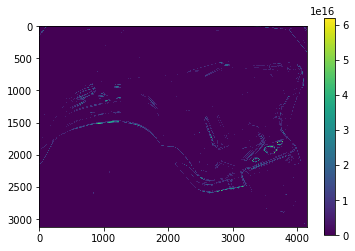

In [104]:
# threshold
threshold = 4 * 1 * np.mean(mag)
mag[mag < threshold] = 0
plt.imshow(mag)
plt.colorbar()

In [105]:
# non-maximal suppression
mag = orientated_non_max_suppression(mag, ang)
# create mask
mag[mag > 0] = 255
mag = mag.astype(np.uint8)
kernel = np.ones((3,3),np.uint8)
result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)

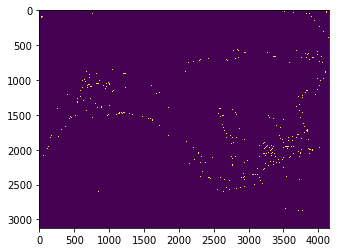

In [106]:
plt.imshow(result)

In [ ]:
def transform(filepath):
    
    img = cv2.imread(filepath)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s = hsv[:,:,1]

    # Otsu thresholding on sat channel
    _, sat = cv2.threshold(s,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #Preparing segmented image
    mask = cv2.merge((sat,sat,sat))
    new= cv2.bitwise_and(img, mask)
    
    filename = os.path.basename(filepath)
    category = os.path.basename(os.path.dirname(filepath))
    destination = os.path.join("data/YE358311/processed",category,filename)
    cv2.imwrite(destination, new) 

In [ ]:
for filepath in healthy_files:
    transform(filepath)

In [ ]:
for filepath in defect_files:
    transform(filepath)

## Background subtraction

In [ ]:
subtractor = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=50, detectShadows=True)
fgMask = subtractor.apply(img_defect_01[:,:,0])
print(np.unique(fgMask))
plt.imshow(fgMask, cmap="gray")

## Edge detection

In [ ]:
hysteresis_min_thresh = 70
hysteresis_max_thresh = 130
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
dilation_steps = 4

In [ ]:
canny = cv2.Canny(image=defect, threshold1=hysteresis_min_thresh,
                          threshold2=hysteresis_max_thresh, apertureSize=3)
plt.imshow(canny, cmap="gray")

In [ ]:
dilated = cv2.dilate(canny, kernel,iterations=dilation_steps)
plt.imshow(dilated, cmap="gray")

In [ ]:
size = np.size(dilated)
skel = np.zeros(dilated.shape, np.uint8)

In [ ]:
img = dilated
done = False

In [ ]:
while not done:
    eroded = cv2.erode(img, kernel)
    temp = cv2.dilate(eroded, kernel)
    temp = cv2.subtract(img, temp)
    skel = cv2.bitwise_or(skel, temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros == size:
        done = True

In [ ]:
plt.imshow(skel, cmap="gray")

## Thresholding

In [ ]:
edges = cv2.Canny(img_defect_01,50,100)

f = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(edges, cmap="gray")